https://github.com/muatik/machine-learning-examples/blob/master/gaussianprocess2.ipynb

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
%matplotlib inline

# sns.set_style("whitegrid")
# plt.style.use("fivethirtyeight")

In [49]:
# Pembacaan File Data Polusi Udara ISPU Excel
DKI1 = pd.read_excel("./Data/Normalization/DATA ISPU - Normalization.xlsx", sheet_name="DKI1")
DKI2 = pd.read_excel("./Data/Normalization/DATA ISPU - Normalization.xlsx", sheet_name="DKI2")
DKI3 = pd.read_excel("./Data/Normalization/DATA ISPU - Normalization.xlsx", sheet_name="DKI3")
DKI4 = pd.read_excel("./Data/Normalization/DATA ISPU - Normalization.xlsx", sheet_name="DKI4")
DKI5 = pd.read_excel("./Data/Normalization/DATA ISPU - Normalization.xlsx", sheet_name="DKI5")

In [50]:
# Menampilkan 5 Data pertama DKI1
DKI1.head()

Tanggal             Wilayah      PM10       SO2        CO        O3  \
0 2017-01-01  DKI1 (Bunderan HI)  0.719512  0.314286  0.458333  0.092308   
1 2017-01-02  DKI1 (Bunderan HI)  0.146341  0.295238  0.270833  0.082051   
2 2017-01-03  DKI1 (Bunderan HI)  0.170732  0.295238  0.291667  0.087179   
3 2017-01-04  DKI1 (Bunderan HI)  0.243902  0.295238  0.395833  0.087179   
4 2017-01-05  DKI1 (Bunderan HI)  0.304878  0.295238  0.458333  0.056410   

        NO2       Max Critical Kategori  
0  0.012821  0.300518     PM10   Sedang  
1  0.000000  0.139896      SO2     Baik  
2  0.012821  0.139896      SO2     Baik  
3  0.012821  0.139896      SO2     Baik  
4  0.012821  0.139896      SO2     Baik

In [51]:
class GP(object):
    
    @classmethod
    def kernel_bell_shape(cls, x, y, delta=1.0):
        return np.exp(-1/2.0 * np.power(x - y, 2) / delta)
    
    @classmethod
    def kernel_laplacian(cls, x, y, delta=1):
        return np.exp(-1/2.0 * np.abs(x - y) / delta)
    
    @classmethod
    def generate_kernel(cls, kernel, delta=1):
        def wrapper(*args, **kwargs):
            kwargs.update({"delta": delta})
            return kernel(*args, **kwargs)
        return wrapper
        
    def __init__(self, x, y, cov_f=None, R=0):
        super().__init__()
        self.x = x
        self.y = y
        self.N = len(self.x)
        self.R = R
        
        self.sigma = []
        self.mean = []
        self.cov_f = cov_f if cov_f else self.kernel_bell_shape
        self.setup_sigma()

    @classmethod
    def calculate_sigma(cls, x, cov_f, R=0):
        N = len(x)
        sigma = np.ones((N, N))
        for i in range(N):
            for j in range(i+1, N):
                cov = cov_f(x[i], x[j])
                sigma[i][j] = cov
                sigma[j][i] = cov
        
        sigma = sigma + R * np.eye(N)
        return sigma
    
    def setup_sigma(self):
        self.sigma = self.calculate_sigma(self.x, self.cov_f, self.R)

    def predict(self, x):
        cov = 1 + self.R * self.cov_f(x, x)
        sigma_1_2 = np.zeros((self.N, 1))
        for i in range(self.N):
            sigma_1_2[i] = self.cov_f(self.x[i], x)

        # SIGMA_1_2 * SIGMA_1_1.I * (Y.T -M)
        # M IS ZERO
        m_expt = (sigma_1_2.T * np.mat(self.sigma).I) * np.mat(self.y).T
        # sigma_expt = cov - (sigma_1_2.T * np.mat(self.sigma).I) * sigma_1_2
        sigma_expt = cov + self.R - (sigma_1_2.T * np.mat(self.sigma).I) * sigma_1_2
        return m_expt, sigma_expt
    
    @staticmethod
    def get_probability(sigma, y, R):
        multiplier = np.power(np.linalg.det(2 * np.pi * sigma), -0.5)
        return multiplier * np.exp(
            (-0.5) * (np.mat(y) * np.dot(np.mat(sigma).I, y).T))

    def optimize(self, R_list, B_list):
        
        def cov_f_proxy(delta, f):
            def wrapper(*args, **kwargs):
                kwargs.update({"delta": delta})
                return f(*args, **kwargs)
            return wrapper
        
        best = (0, 0, 0)
        history = []
        for r in R_list:
            best_beta = (0, 0)
            for b in B_list:
                sigma = gaus.calculate_sigma(self.x, cov_f_proxy(b, self.cov_f), r)
                marginal = b* float(self.get_probability(sigma, self.y, r))
                if marginal > best_beta[0]:
                    best_beta = (marginal, b)
            history.append((best_beta[0], r, best_beta[1]))
        return sorted(history)[-1], np.mat(history)

Setting up a gaussian processor

In [53]:
DKI1['Tanggal']

0      2017-01-01
1      2017-01-02
2      2017-01-03
3      2017-01-04
4      2017-01-05
          ...    
1760   2021-10-27
1761   2021-10-28
1762   2021-10-29
1763   2021-10-30
1764   2021-10-31
Name: Tanggal, Length: 1765, dtype: datetime64[ns]

In [57]:
# x = DKI1['Tanggal']
# x = list(range(0, 5))
x = list(range(0, 1765))
y = DKI1['PM10']
x = np.array(x)
gaus = GP(x,y)

C:\Users\ismat\AppData\Local\Temp/ipykernel_4412/2400592953.py:7: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x_guess, y_pred[0] - np.sqrt(y_pred[1]) * 3, "r:")
C:\Users\ismat\AppData\Local\Temp/ipykernel_4412/2400592953.py:8: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x_guess, y_pred[0] + np.sqrt(y_pred[1]) * 3, "r:")


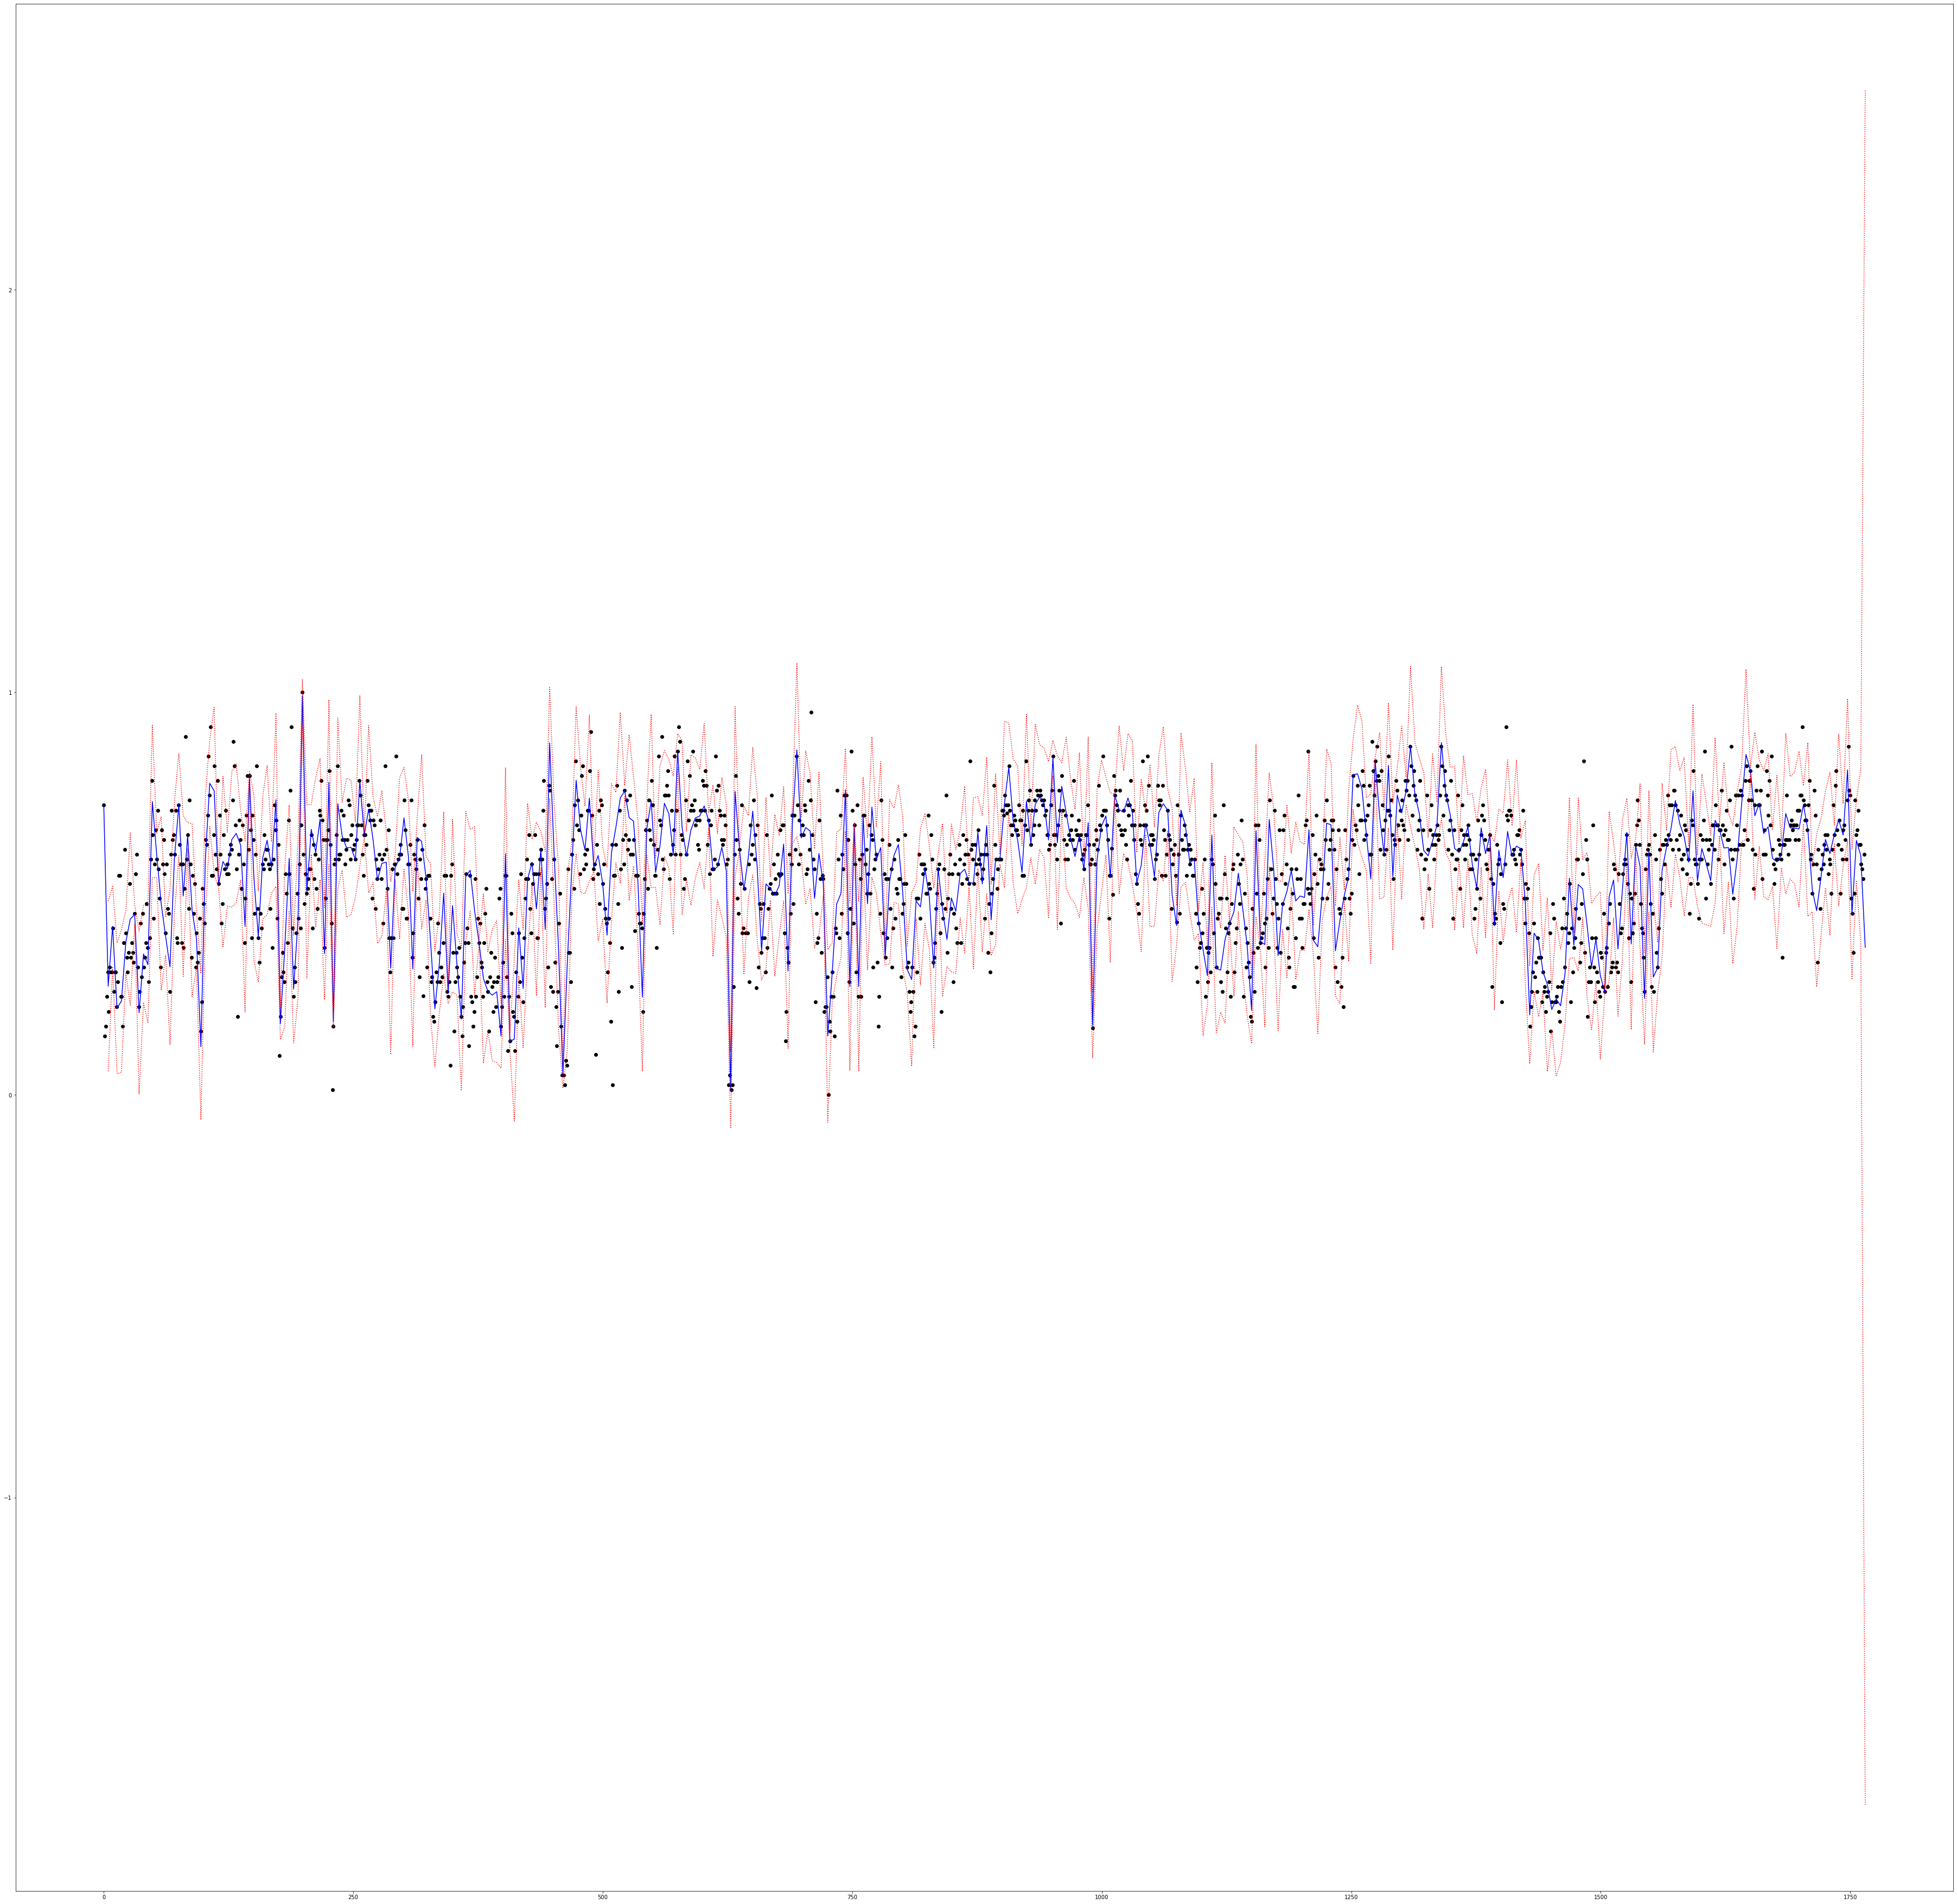

In [58]:
x_guess = np.linspace(0, 1765, 400)
y_pred = np.vectorize(gaus.predict)(x_guess)

plt.figure(figsize=(64, 64))
plt.scatter(x, y, c="black")
plt.plot(x_guess, y_pred[0], c="b")
plt.plot(x_guess, y_pred[0] - np.sqrt(y_pred[1]) * 3, "r:")
plt.plot(x_guess, y_pred[0] + np.sqrt(y_pred[1]) * 3, "r:")

In [59]:
def create_case(kernel, R=0):
    x = list(range(0, 1765))
    y = DKI1['PM10']
    x = np.array(x)
    gaus = GP(x, y, kernel, R=R)

    x_guess = np.linspace(0, 1765, 400)
    y_pred = np.vectorize(gaus.predict)(x_guess)
    
    plt.scatter(x, y, c="black")
    plt.plot(x_guess, y_pred[0], c="b")
    plt.plot(x_guess, y_pred[0] - np.sqrt(y_pred[1]) * 3, "r:")
    plt.plot(x_guess, y_pred[0] + np.sqrt(y_pred[1]) * 3, "r:")

The effects of regularization parameter

C:\Users\ismat\AppData\Local\Temp/ipykernel_4412/1684564787.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot("32{}".format(i+1))
C:\Users\ismat\AppData\Local\Temp/ipykernel_4412/1684564787.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot("32{}".format(i+1))
C:\Users\ismat\AppData\Local\Temp/ipykernel_4412/1684564787.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot("32{}".format(i+1))
C:\Users\ismat\AppData\Local\Temp/ipykernel_4412/1684564787.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releas

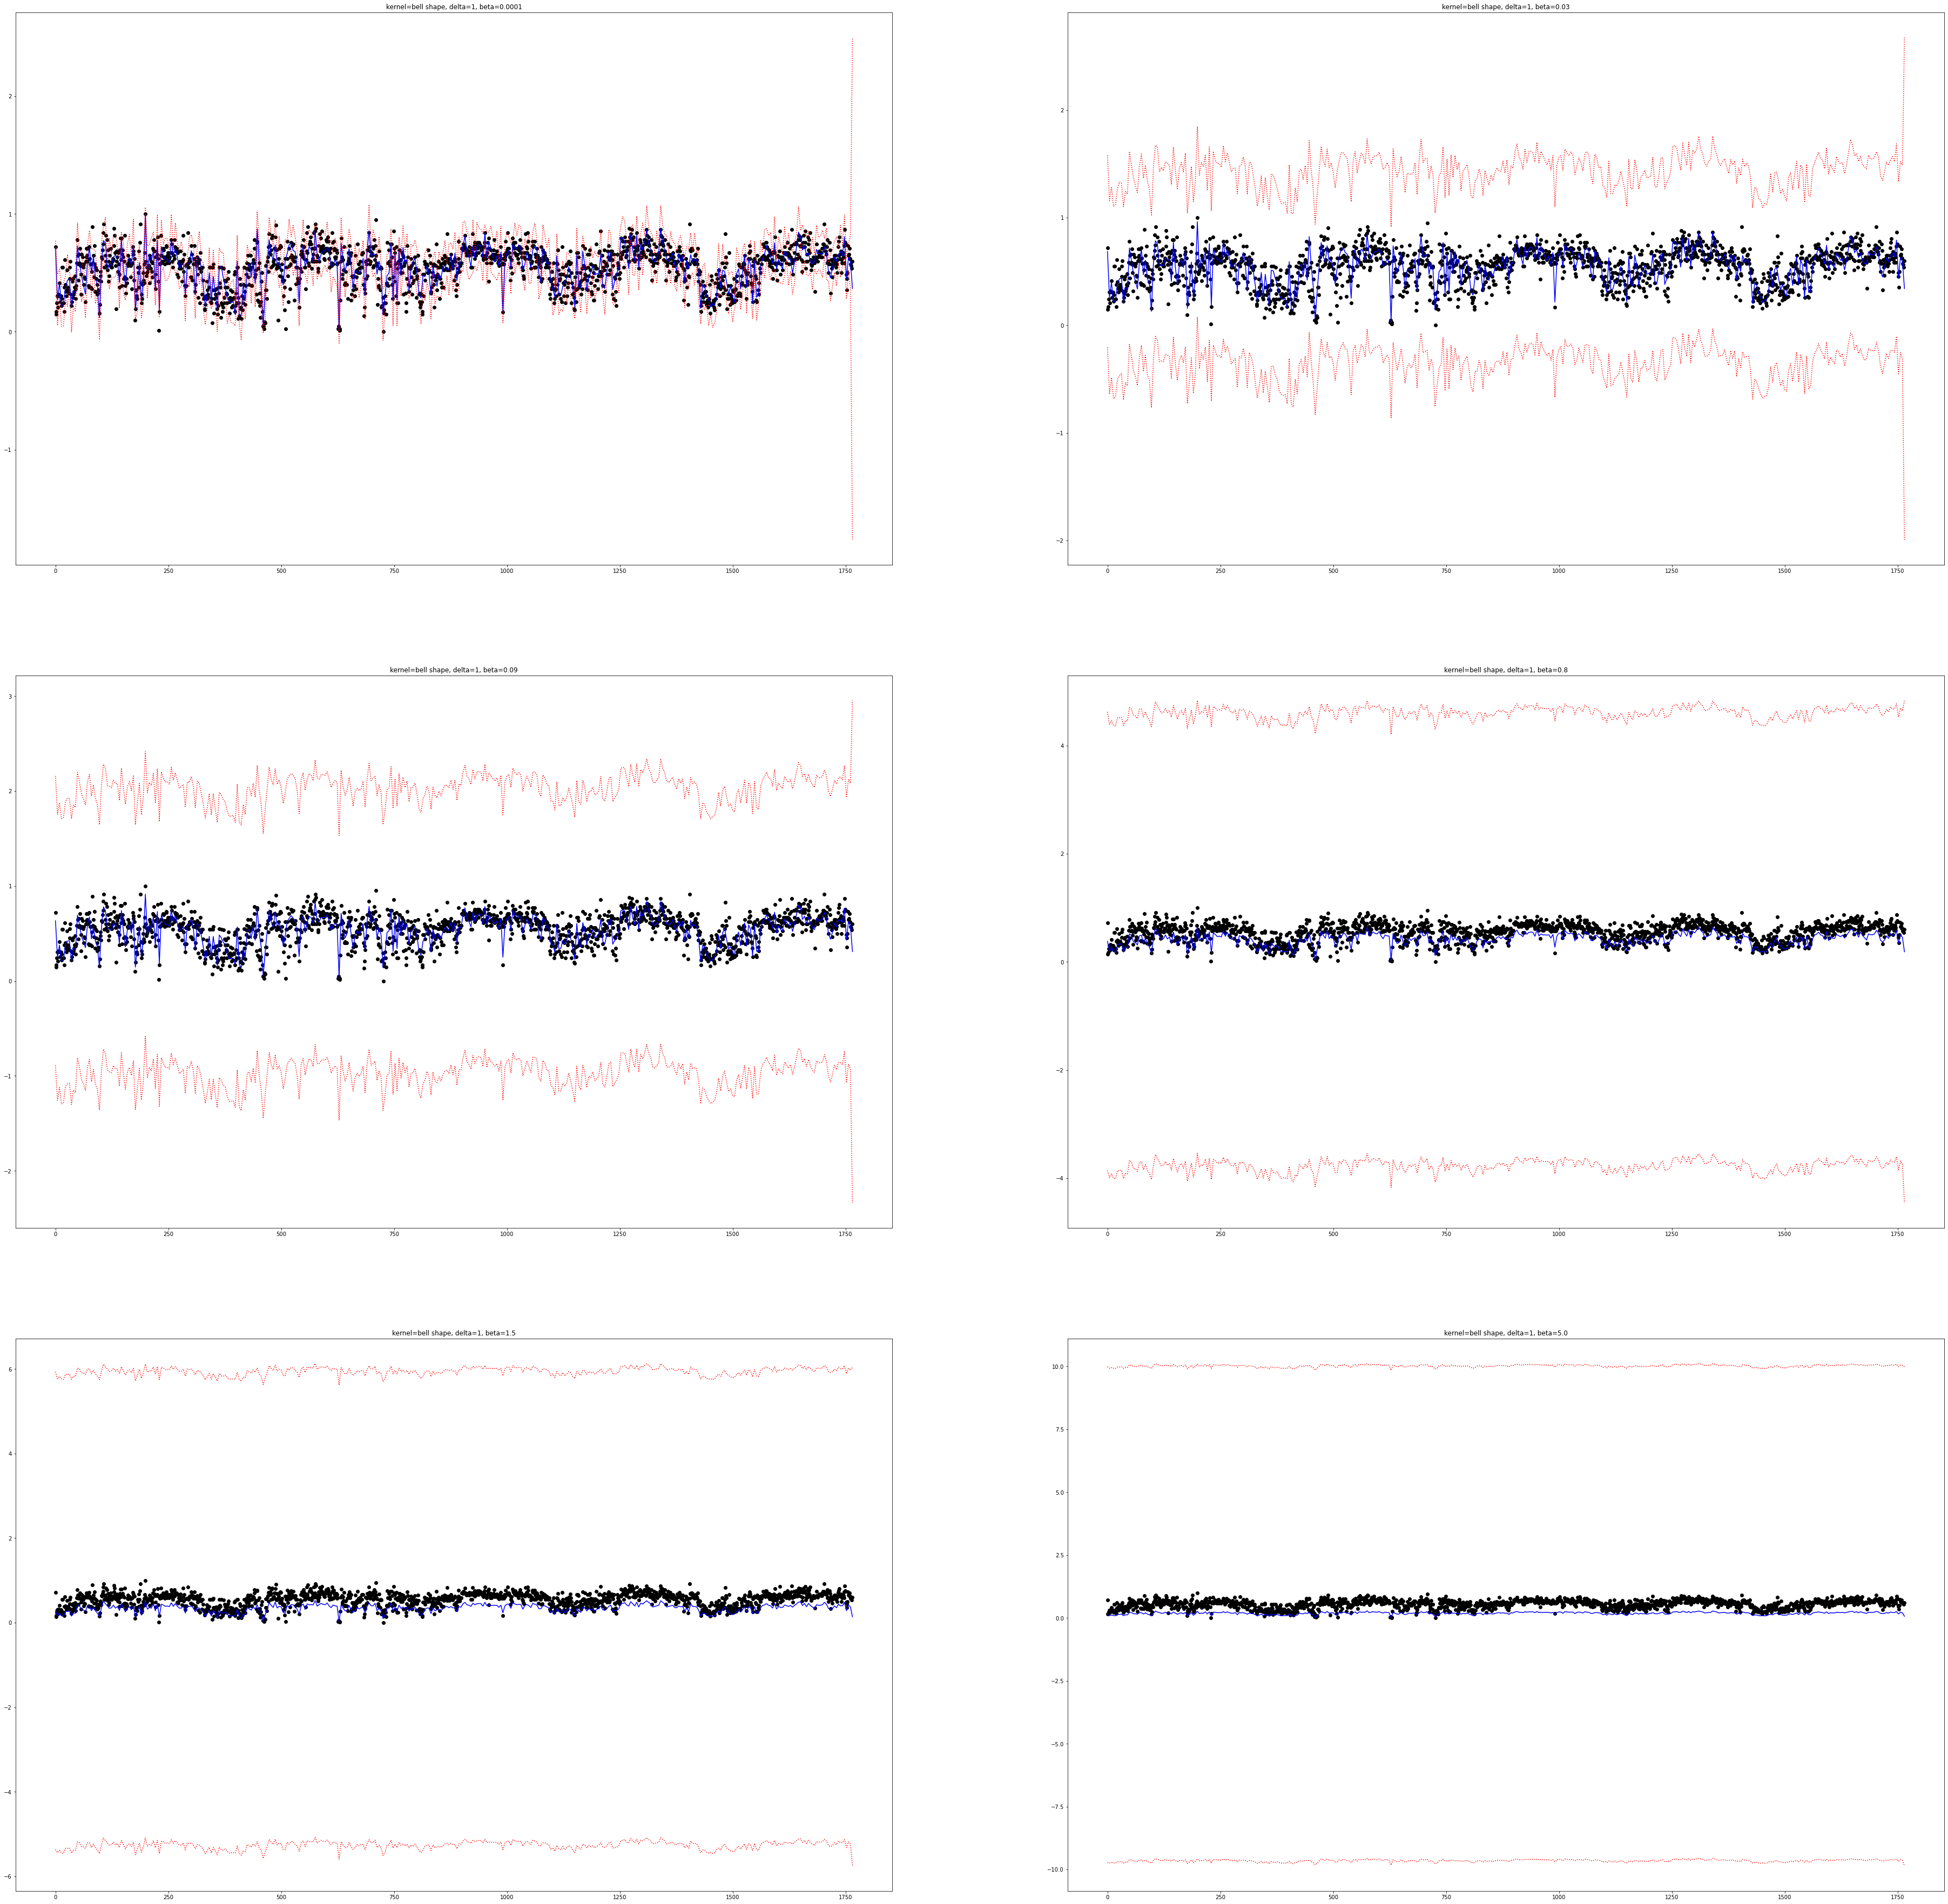

In [61]:
plt.figure(figsize=(64, 64))
for i, r in enumerate([0.0001, 0.03, 0.09, 0.8, 1.5, 5.0]):
    plt.subplot("32{}".format(i+1))
    plt.title("kernel={}, delta={}, beta={}".format("bell shape", 1, r))
    create_case(
        GP.generate_kernel(GP.kernel_bell_shape, delta=1), R=r)

The effects of delta

C:\Users\ismat\AppData\Local\Temp/ipykernel_4412/1718007751.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot("32{}".format(i+1))
C:\Users\ismat\AppData\Local\Temp/ipykernel_4412/1718007751.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot("32{}".format(i+1))
C:\Users\ismat\AppData\Local\Temp/ipykernel_4412/1718007751.py:3: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot("32{}".format(i+1))
C:\Users\ismat\AppData\Local\Temp/ipykernel_4412/1306350996.py:12: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(x_guess, y_pred[0] - np.sqrt(y_pred[1]) * 3, "r:")
C:\Users\ismat\AppData\Local\Temp/ipyk

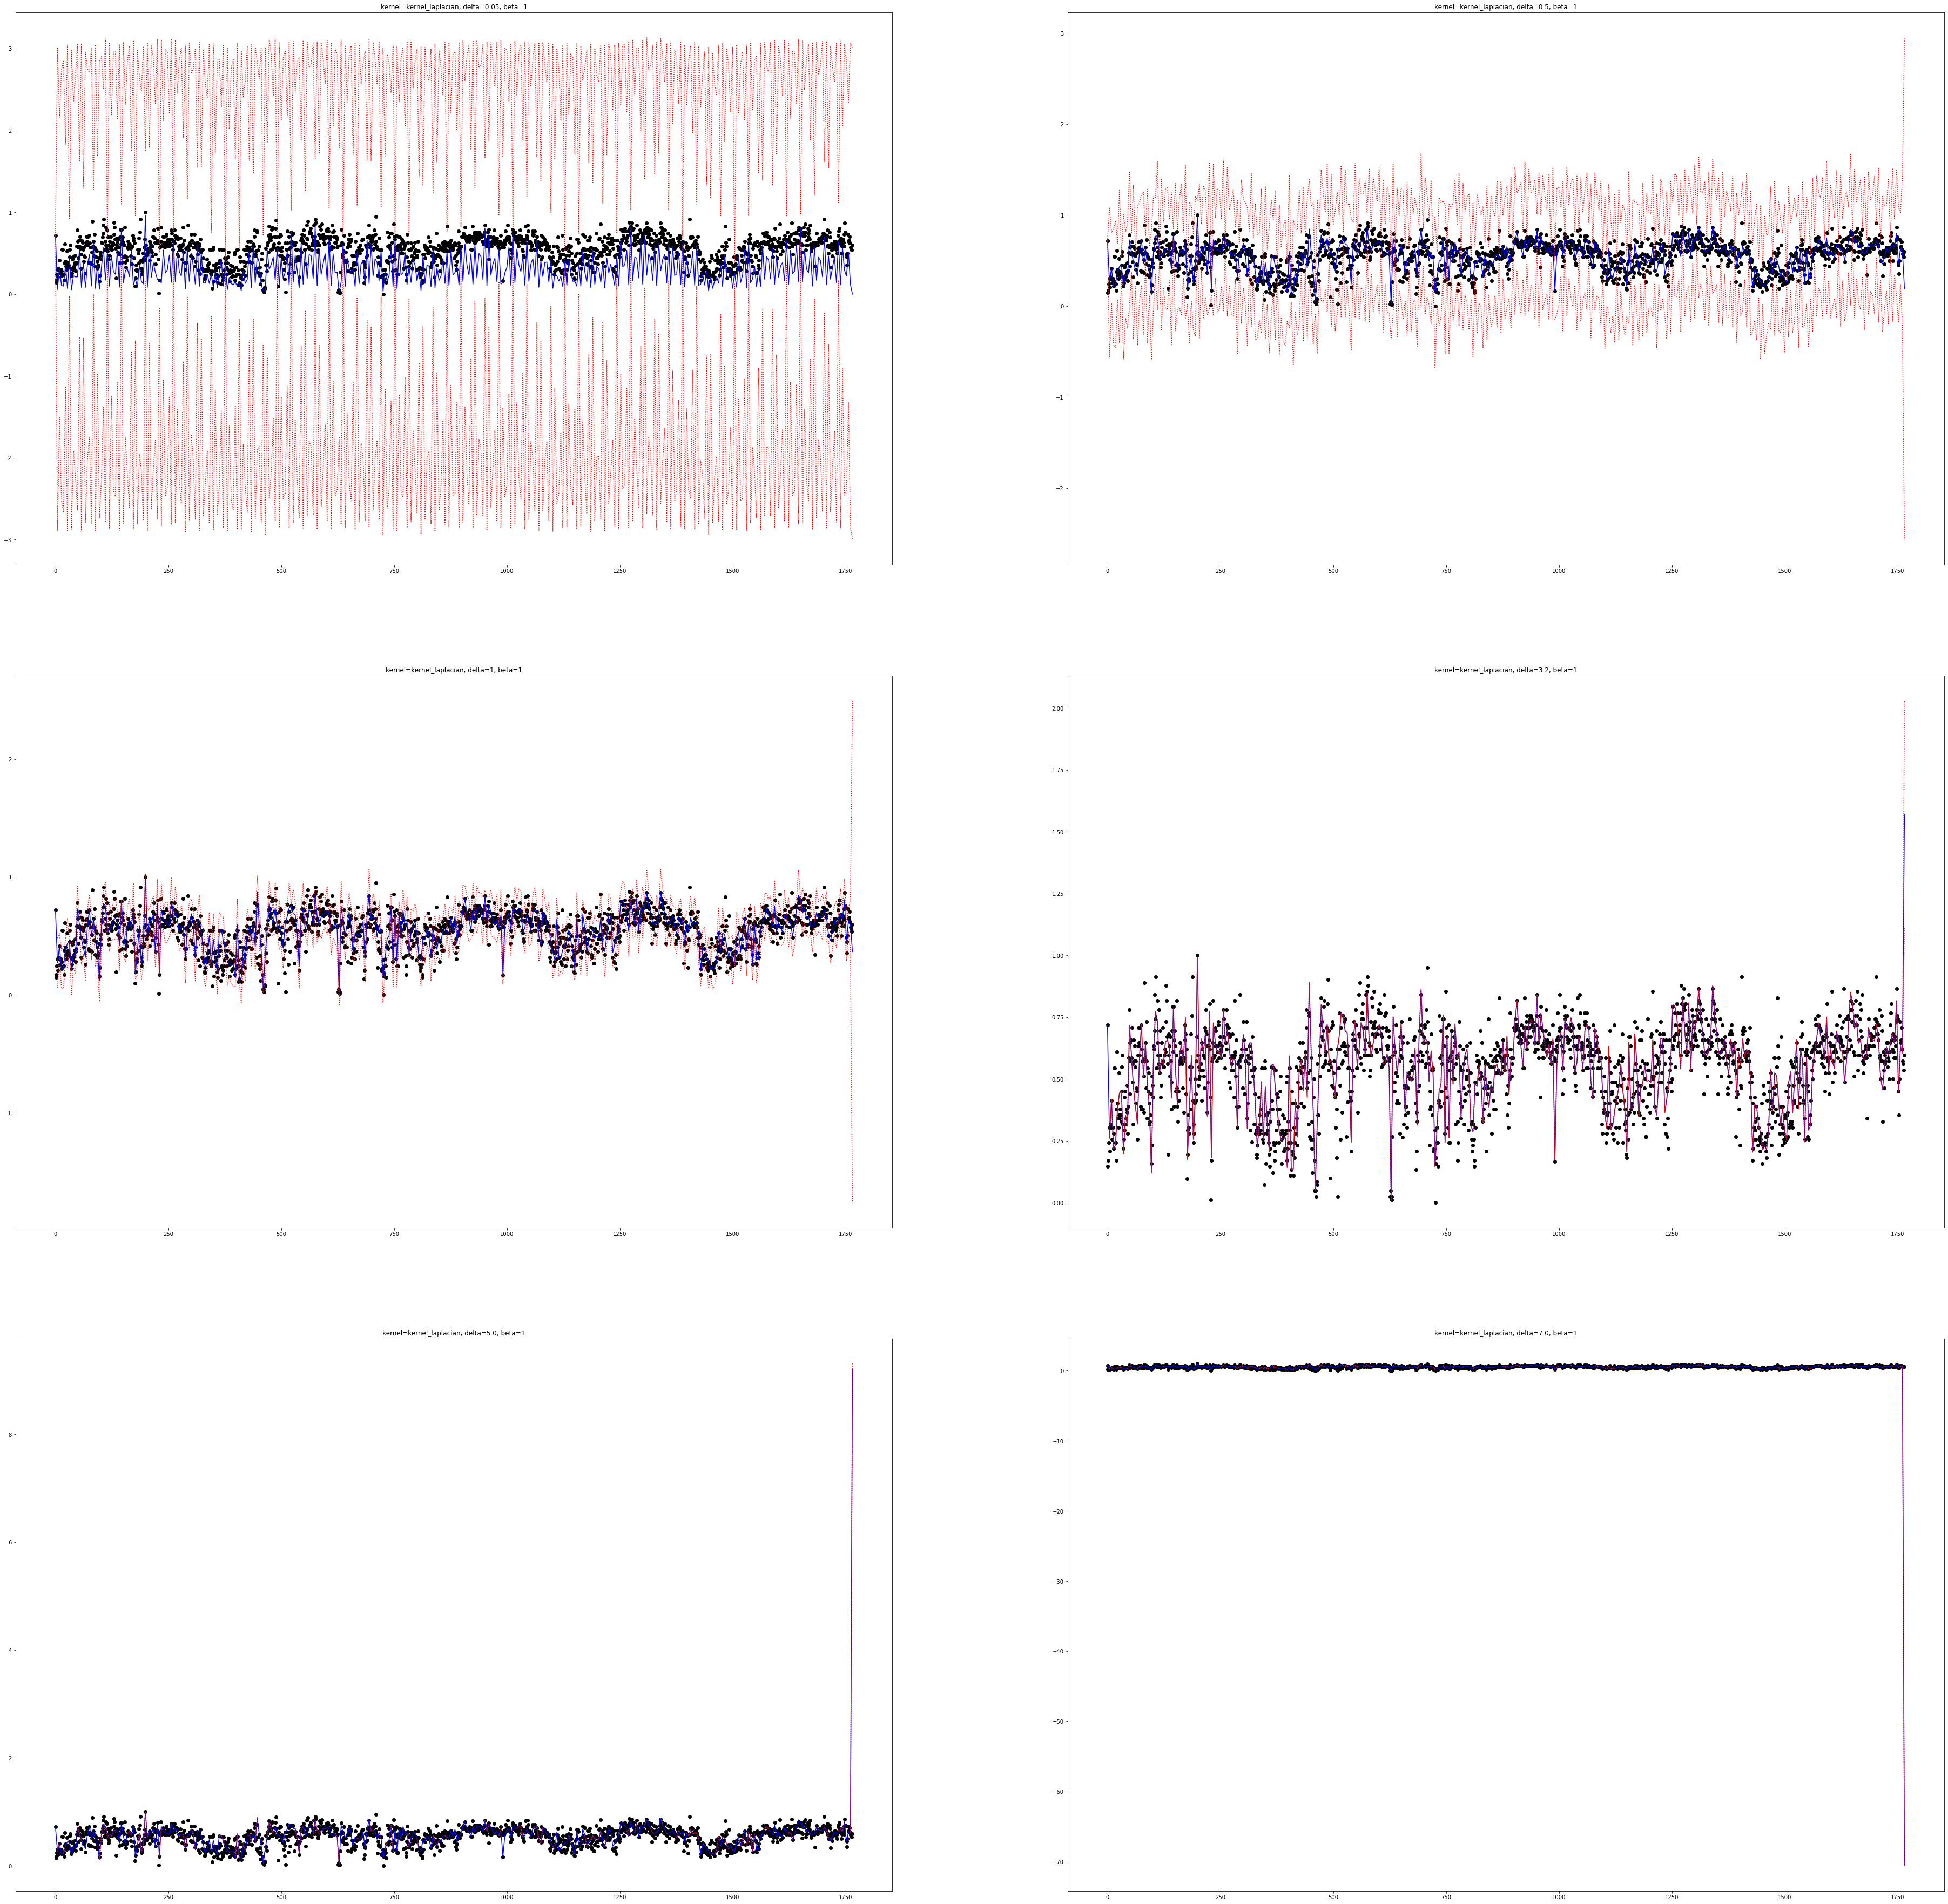

In [62]:
plt.figure(figsize=(64, 64))
for i, d in enumerate([0.05, 0.5, 1, 3.2, 5.0, 7.0]):
    plt.subplot("32{}".format(i+1))
    plt.title("kernel={}, delta={}, beta={}".format("kernel_laplacian", d, 1))
    create_case(
        GP.generate_kernel(GP.kernel_bell_shape, delta=d), R=0)

Finding the optimal parameters

In [63]:
x = list(range(0, 1765))
y = DKI1['PM10']
x = np.array(x)
# x = np.array([-2, -1, 3.5]);
# y = np.array([4.1, 0.9, 12.3])
gaus = GP(x, y)
R_list = np.linspace(0.0, 1, 100)
B_list = np.linspace(0.1, 10, 20)
best_params, history = gaus.optimize(R_list, B_list)
plt.plot(history[:,1], history[:,2])
print("best parameters (probability, r, b): ", best_params)
plt.show()
create_case(
        GP.generate_kernel(GP.kernel_bell_shape, delta=10), R=1)

C:\Users\ismat\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2158: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\ismat\AppData\Local\Temp/ipykernel_4412/4176825379.py:61: RuntimeWarning: divide by zero encountered in power
  multiplier = np.power(np.linalg.det(2 * np.pi * sigma), -0.5)
C:\Users\ismat\AppData\Local\Temp/ipykernel_4412/4176825379.py:62: RuntimeWarning: invalid value encountered in multiply
  return multiplier * np.exp(
C:\Users\ismat\AppData\Local\Temp/ipykernel_4412/4176825379.py:62: RuntimeWarning: overflow encountered in exp
  return multiplier * np.exp(


KeyboardInterrupt: 